In [1]:
import numpy as np
import os
import cv2
import random 
import tensorflow as tf

2023-04-24 08:50:25.819911: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 08:50:25.873296: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 08:50:25.874893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 08:50:26.894211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
main = "/home/second/Desktop/TB_Chest_Radiography_Database"
normal = "/home/second/Desktop/TB_Chest_Radiography_Database/Normal/"
tuberculosis = "/home/second/Desktop/TB_Chest_Radiography_Database/Tuberculosis/"

In [3]:
print("no. of tuberculosis images :" ,len(os.listdir(tuberculosis)))
print("\nno. of normal images :" ,len(os.listdir(normal)))

no. of tuberculosis images : 700

no. of normal images : 3500


In [4]:


tf.random.set_seed(100)
np.random.seed(100)



In [5]:
train_dir = os.path.join(main, 'train')
test_dir = os.path.join(main, 'test')
validation_dir = os.path.join(main, 'validation')

if not os.path.exists(main):
    os.mkdir(main)
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
if os.path.exists(validation_dir) or os.path.exists(main) or os.path.exists(train_dir):
    pass

In [6]:
Labels = ["Normal", "Tuberculosis"]
image_size = 520

train_percentage = 0.7
test_percentage = 0.1
validation_percentage = 0.2

In [7]:
import shutil

for cat in Labels:
    cat_dir = os.path.join(main,cat)

    os.makedirs(os.path.join(train_dir, cat))
    os.makedirs(os.path.join(test_dir, cat))
    os.makedirs(os.path.join(validation_dir, cat))

    image_files = [f for f in os.listdir(cat_dir) if f.endswith('.png')]

    random.shuffle(image_files)

    num_images = len(image_files)
    num_train = int(num_images * train_percentage)
    num_test = int(num_images * test_percentage)
    num_validation = num_images - num_train - num_test

    train_files = image_files[:num_train]
    test_files = image_files[num_train:num_train+num_test]
    validation_files = image_files[num_train+num_test:]

    for filename in train_files:
        src = os.path.join(cat_dir, filename)
        dst = os.path.join(train_dir, cat, filename)
        shutil.copyfile(src, dst)

    for filename in test_files:
        src = os.path.join(cat_dir, filename)
        dst = os.path.join(test_dir, cat, filename)
        shutil.copyfile(src, dst)

    for filename in validation_files:
        src = os.path.join(cat_dir, filename)
        dst = os.path.join(validation_dir, cat, filename)
        shutil.copyfile(src, dst)

In [8]:

from keras.preprocessing.image import ImageDataGenerator

imageDataGenerator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [9]:
train_gen = imageDataGenerator.flow_from_directory(
    train_dir,
    target_size = (200, 200),
     batch_size = 12,
     shuffle=True,
     class_mode = 'binary',
)
test_gen = imageDataGenerator.flow_from_directory(
    test_dir,
    target_size = (200, 200),
     batch_size = 12,
     shuffle=True,
     class_mode = 'binary',
)
val_gen = imageDataGenerator.flow_from_directory(
    validation_dir,
    target_size = (200, 200),
     batch_size = 12,
     shuffle=True,
     class_mode = 'binary',
)

Found 2939 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 841 images belonging to 2 classes.


In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights


array([0.59979592, 3.00511247])

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization



In [12]:
model=Sequential(name='classifier')
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(200,200,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(200,200,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(filters=192, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=192, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 196, 196, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                        

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_gen),
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=len(val_gen),callbacks=[model_checkpoint_callback])

/tmp/ipykernel_6560/1562268765.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/10


2023-04-24 08:51:34.618639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


245/245 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.8959

2023-04-24 09:05:53.227436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.85731, saving model to model.hdf5
245/245 [==============================] - 911s 4s/step - loss: 0.6957 - accuracy: 0.8959 - val_loss: 0.8096 - val_accuracy: 0.8573
Epoch 2/10
245/245 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.9248
Epoch 2: val_accuracy improved from 0.85731 to 0.92271, saving model to model.hdf5
245/245 [==============================] - 813s 3s/step - loss: 0.2793 - accuracy: 0.9248 - val_loss: 0.2544 - val_accuracy: 0.9227
Epoch 3/10
245/245 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9418
Epoch 3: val_accuracy improved from 0.92271 to 0.95006, saving model to model.hdf5
245/245 [==============================] - 911s 4s/step - loss: 0.1813 - accuracy: 0.9418 - val_loss: 0.1156 - val_accuracy: 0.9501
Epoch 4/10
245/245 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9544
Epoch 4: val_accuracy did not improve from 0.95006
245/245 [=========

In [14]:
def predict(image,model):
    labels = ['Normal','Tuberculosis']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,200,200,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import clear_output
clear_output()


1/1 [==============================] - 0s 110ms/step


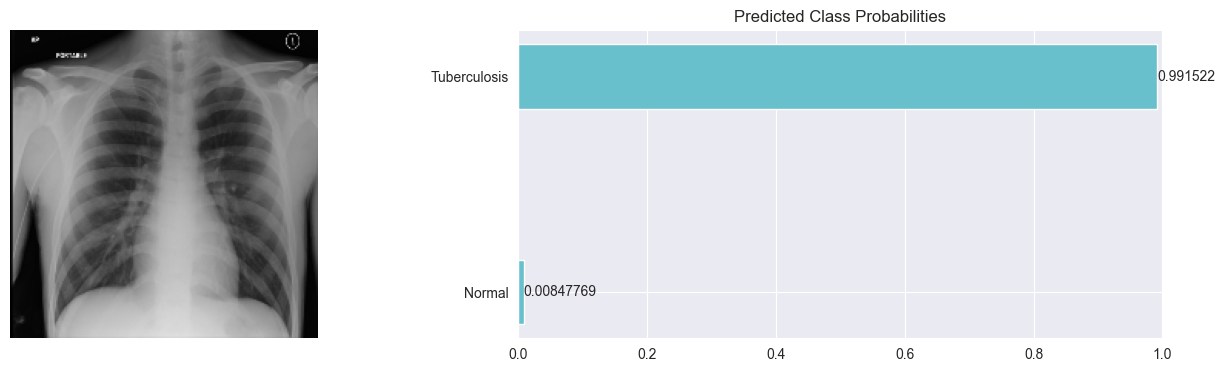

Actual   :
Predicted: Tuberculosis
--------------------------------------------------------------------------------




In [19]:


image = cv2.imread("/home/second/Downloads/Normal-3.png")
image = cv2.resize(image, (200, 200))
pred, probabilities = predict(image, model)

x = list(probabilities.keys())
y = list(probabilities.values())

sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
ax[0].imshow(image)
ax[0].axis('off')

bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd'])
ax[1].bar_label(bars)

ax[1].set_title('Predicted Class Probabilities')
plt.xlim([0, 1])
plt.show()

print('Actual   :')
print('Predicted:', pred)
print('-'*80)
print('\n')
